In [4]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# Choose variants here:

In [5]:
trained_model = False
arch = 'ResNet18'
target_idx = 1   # the index of the target image in the batch

## System setup:

In [7]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('ImageNet', defs, 
                                                                      data_path='/mnt/ssd4/weiyang/Dataset/')

model = torchvision.models.resnet18(pretrained=False)
kept_weight = model.fc.weight[target_idx].detach().clone()
kept_bias = model.fc.bias[target_idx].detach().clone()
with torch.no_grad():
    model.fc.weight.data = torch.zeros((1000,512), dtype=torch.float)
    model.fc.weight[target_idx] = kept_weight
    model.fc.bias.data = torch.full((1,1000),10000, dtype=torch.float).flatten()
    model.fc.bias[target_idx] = kept_bias
model.to(**setup)
model.eval();

Currently evaluating -------------------------------:
Monday, 21. February 2022 02:38PM
CPUs: 24, GPUs: 2 on chfa01-desktop.
GPU : NVIDIA GeForce RTX 3090


In [8]:
dm = torch.as_tensor(inversefed.consts.imagenet_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.imagenet_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

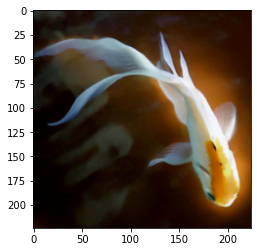

In [9]:
ground_truth = torch.stack([validloader.dataset[50*i][0] for i in range(8)]).to(**setup)
labels = torch.tensor([validloader.dataset[50*i][1] for i in range(8)]).to(**setup)

labels = labels.long()
plot(ground_truth[target_idx].unsqueeze(0));

### Save Ground Truth Image

In [10]:
ground_truth_denormalized = torch.clamp(ground_truth[target_idx].unsqueeze(0) * ds + dm, 0, 1)
torchvision.utils.save_image(ground_truth_denormalized, f'./images/fishing_data/{arch}_ImageNet{target_idx}_input.png')

In [11]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach()*8 for grad in input_gradient]
full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
print(f'Full gradient norm is {full_norm:e}.')

Full gradient norm is 7.784260e+00.


It: 0. Rec. loss: 0.1505.
It: 500. Rec. loss: 0.1653.
It: 1000. Rec. loss: 0.1116.
It: 1500. Rec. loss: 0.0864.
It: 2000. Rec. loss: 0.0749.
It: 2500. Rec. loss: 0.0660.
It: 3000. Rec. loss: 0.0635.
It: 3500. Rec. loss: 0.0613.
It: 4000. Rec. loss: 0.0575.
It: 4500. Rec. loss: 0.0600.
It: 5000. Rec. loss: 0.0626.
It: 5500. Rec. loss: 0.0607.
It: 6000. Rec. loss: 0.0572.
It: 6500. Rec. loss: 0.0598.
It: 7000. Rec. loss: 0.0562.
It: 7500. Rec. loss: 0.0570.
It: 8000. Rec. loss: 0.0564.
It: 8500. Rec. loss: 0.0596.
It: 9000. Rec. loss: 0.0585.
It: 9500. Rec. loss: 0.0207.
It: 10000. Rec. loss: 0.0157.
It: 10500. Rec. loss: 0.0121.
It: 11000. Rec. loss: 0.0107.
It: 11500. Rec. loss: 0.0095.
It: 12000. Rec. loss: 0.0089.
It: 12500. Rec. loss: 0.0084.
It: 13000. Rec. loss: 0.0072.
It: 13500. Rec. loss: 0.0075.
It: 14000. Rec. loss: 0.0075.
It: 14500. Rec. loss: 0.0067.
It: 15000. Rec. loss: 0.0064.
It: 15500. Rec. loss: 0.0041.
It: 16000. Rec. loss: 0.0039.
It: 16500. Rec. loss: 0.0044.
It: 

"\ndata = inversefed.metrics.activation_errors(model, output, ground_truth)\n\nfig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))\naxes[0, 0].semilogy(list(data['se'].values())[:-3])\naxes[0, 0].set_title('SE')\naxes[0, 1].semilogy(list(data['mse'].values())[:-3])\naxes[0, 1].set_title('MSE')\naxes[0, 2].plot(list(data['sim'].values())[:-3])\naxes[0, 2].set_title('Similarity')\n\nconvs = [val for key, val in data['mse'].items() if 'conv' in key]\naxes[1, 0].semilogy(convs)\naxes[1, 0].set_title('MSE - conv layers')\nconvs = [val for key, val in data['mse'].items() if 'conv1' in key]\naxes[1, 1].semilogy(convs)\nconvs = [val for key, val in data['mse'].items() if 'conv2' in key]\naxes[1, 1].semilogy(convs)\naxes[1, 1].set_title('MSE - conv1 vs conv2 layers')\nbns = [val for key, val in data['mse'].items() if 'bn' in key]\naxes[1, 2].plot(bns)\naxes[1, 2].set_title('MSE - bn layers')\nfig.suptitle('Error between layers');\n"

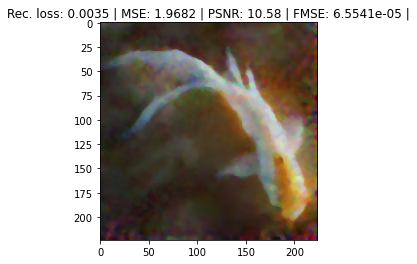

In [12]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='top10',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=24_000,
              total_variation=1e-6,
              init='randn',
              filter='median',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output, stats = rec_machine.reconstruct(input_gradient, labels[target_idx].unsqueeze(0), img_shape=(3, 224, 224))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

'''
data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');
'''

In [16]:
output_denormalized = torch.clamp(output * ds + dm, 0, 1)
torchvision.utils.save_image(output_denormalized, f'./images/fishing_data/{arch}_ImageNet{target_idx}_untrained_output.png')